In [80]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob
from collections import defaultdict
import numpy as np

## Core components

#### Parse JSON logs

In [56]:
def parse_champions(logs_file_iter):
    result = {}
    current_line = next(logs_file_iter, '{}')
    line_json = json.loads(current_line)
    while line_json.get('type', None) == 'ChampionSpawnedReport':
        name = line_json['value']['controller_name']
        coords = line_json['value']['coords']
        champion_data = {
            'name': name,
            'start_coords': coords,
            'last_coords': coords,
            'failed_steps': [],  # every item is a dict {'episode', 'error_text', 'coords'}
            'actions': [],
            'episode_died': -1,
            'last_attack_type': None
        }
        result[name] = champion_data
        current_line = next(logs_file_iter, '{}')
        line_json = json.loads(current_line)
    return result, current_line if current_line != '{}' else None

In [60]:
def parse_game_course(current_line, logs_file_iter, game_report):
    if current_line is None:
        return None
    champions_info = game_report['bots']
    
    line_json = json.loads(current_line)
    episode_number = 0
    mist_started = False
    while line_json.get('type', None) not in ('GameStartReport', None):
        event_type = line_json['type']
        bot_name = line_json.get('value', {}).get('controller_name', None)
        bot_data = champions_info.get(bot_name, None)
        
        if event_type == 'EpisodeStartReport':
            game_report['episodes_number'] = episode_number
            episode_number = int(line_json['value']['episode_number'])
        elif line_json['severity'] == 'WARNING':
            error_text = line_json['value']['exception']
            coords = bot_data['last_coords']
            bot_data['failed_steps'].append({
                'episode': episode_number,
                'error_text': error_text,
                'coords': coords
            })
        elif event_type == 'ChampionPickedActionReport':
            action = line_json['value']['action_name']
            bot_data['actions'].append(action)
        elif event_type == 'ChampionEnteredTileReport':
            new_coords = line_json['value']['tile_coords']
            bot_data['last_coords'] = new_coords
        elif event_type == 'ChampionDeathReport':
            bot_data['episode_died'] = episode_number
        elif event_type == 'ChampionDamagedByMistReport':
            bot_data['last_attack_type'] = 'mist'
        elif event_type == 'ChampionDamagedByWeaponCutReport':
            bot_data['last_attack_type'] = 'weapon'
        elif event_type == 'MistRadiusReducedReport' and not mist_started:
            mist_started = True
            game_report['mist_episode'] = episode_number
        
        current_line = next(logs_file_iter, '{}')
        line_json = json.loads(current_line)
    return current_line if current_line != '{}' else None

In [61]:
def parse_games_json_logs(logs_path):
    with open(logs_path) as logs_file:
        logs_file_iter = iter(logs_file)
        result = []
        current_line = next(logs_file_iter, None)
        while current_line is not None:
            game_json = json.loads(current_line)
            arena_json = json.loads(next(logs_file_iter, 'null'))
            menhir_json = json.loads(next(logs_file_iter, 'null'))
            champions, current_line = parse_champions(logs_file_iter)
            if not all((arena_json, menhir_json, champions)):
                print('Not all metadata provided')
                break
            game_report = {
                'game_number': int(game_json['value']['game_number']),
                'mist_episode': -1,
                'menhir_pos': menhir_json['value']['position'],
                'arena_name': arena_json['value']['arena_name'],
                'bots': champions,
                'episodes_number': 0
            }

            current_line = parse_game_course(current_line, logs_file_iter, game_report)
            result.append(game_report)
    return result

#### Parsed data analysis

In [120]:
def plot_bot_survival_dynamics(games, bot_name, figure):
    survivals = []
    failures = []
    for game in games:
        bot_died = game['bots'][bot_name]['episode_died']
        bot_died = bot_died if bot_died > 0 else game['episodes_number']
        game_number = game['game_number']
        survivals.append([game_number, bot_died])
        if game['bots'][bot_name]['failed_steps']:
            failures.append([game_number, bot_died])
    survivals = np.array(survivals)
    plt.plot(survivals[:,0], survivals[:,1], figure=figure, label=bot_name, linewidth=0.6, color=COLORS[bot_name])
    if failures:
        failures = np.array(failures)
        plt.scatter(failures[:,0], failures[:,1], marker='x', figure=figure, color=COLORS[bot_name])

## Before running the parser
> The parser `.ipynb` is put under `GUPB/log-parse` and all paths to logs are relative to this location. Be sure that the files are downloaded and placed there, because they are not under Git

**The schema:**
```json
[
    {
        "game_number": int,
        "mist_episode": int (-1 if a game ended quicker than the mist started),
        "menhir_post": [int, int],
        "arena_name": string,
        "episodes_number": int,
        "bots": {
            "bot_name_1": {
                "name": string,
                "start_coords": [int, int],
                "last_coords": [int, int],
                "failed_steps": [
                    {
                        "episode": int,
                        "error_text": string,
                        "coords": [int, int]
                    },
                    ...
                ],
                "actions": [string, string, ...],
                "episode_died": int (-1 if a last bot standing),
                "last_attack_type": string (either 'mist' or 'weapon')
            },
            "bot_name_2": ...,
            ...
        }
    },
    ...
]
```

## Example log

In [62]:
example_path = 'example_log.json'
example_parsed_data = parse_games_json_logs(example_path)

In [66]:
[f'{key}: {example_parsed_data[0][key]}' for key in example_parsed_data[0] if key != 'bots']

['game_number: 1',
 'mist_episode: 25',
 'menhir_pos: [9, 9]',
 'arena_name: isolated_shrine',
 'episodes_number: 477']

## 11:15 games

In [9]:
DIR_PATH_11_15 = '11_15__2021_10_24'
log_files = glob.glob(f'{DIR_PATH_11_15}/*.json')

In [21]:
json_log_path = log_files[0]

In [67]:
games = parse_games_json_logs(json_log_path)

In [75]:
games_df = pd.DataFrame(games)
games_df.head()

,game_number,mist_episode,menhir_pos,arena_name,bots,episodes_number
0,1,20,"[9, 9]",isolated_shrine,{'EkonometronControllerJohnathan': {'name': 'E...,182
1,2,20,"[9, 9]",isolated_shrine,{'EkonometronControllerJohnathan': {'name': 'E...,179
2,3,20,"[9, 9]",isolated_shrine,"{'BB8': {'name': 'BB8', 'start_coords': [7, 14...",103
3,4,15,"[9, 9]",isolated_shrine,{'EvaderController--MarwinWise': {'name': 'Eva...,119
4,5,20,"[9, 9]",isolated_shrine,"{'Felix': {'name': 'Felix', 'start_coords': [8...",194


In [69]:
bins_number = 20
bin_size = len(games) // bins_number

### Survival dynamics

In [117]:
COLORS = {
    'EvaderController--MarwinWise': 'limegreen',
    'FunnyController': 'purple',
    'BerserkBotRagnar': 'darkred',
    'R2D2': 'navy',
    'BB8': 'orange',
    'Bandyta1.0': 'teal',
    'EkonometronControllerJohnathan': 'brown',
    'Felix': 'yellow',
    'WIETnamczykAdam': 'black'
}

In [97]:
bin_1 = games[:bins_number]
games_length = np.array([[game['game_number'], game['episodes_number']] for game in bin_1])

> TODO: should be also done grouping games by arena

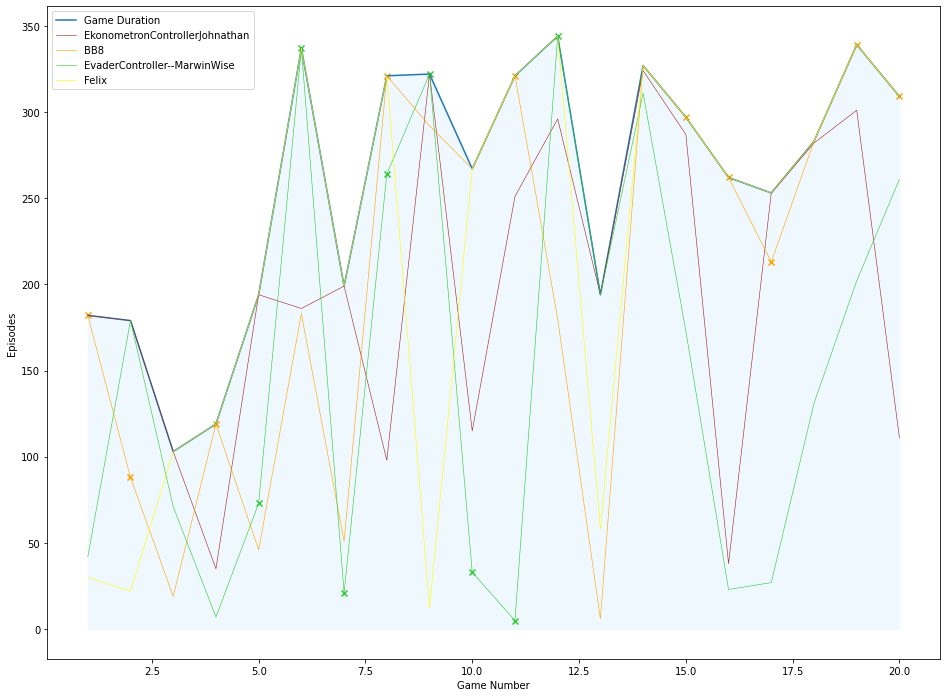

In [121]:
fig = plt.figure(figsize=(16, 12))
plt.plot(games_length[:,0], games_length[:,1], figure=fig, label='Game Duration')
plt.fill_between(games_length[:,0], games_length[:,1], color='aliceblue')
for bot in bin_1[0]['bots']:
    plot_bot_survival_dynamics(bin_1, bot, fig)
plt.legend()
plt.xlabel('Game Number')
_ = plt.ylabel('Episodes')

### Death Reasons

### The Map

### Heatmap of Deaths